# Artificial Neural Network (Project 2)

## Regression goal
- We want to predict the target value streams based on certain input columns. 

### Neural Network Considerations

- How many hidden layers?
- How many hidden units?
- What kind of layers?
- What performance is adequate?

### Preprocessing of the data

- Read data
- One-hot-encoding
- Remove outliers
- Keep columns of interest
- Normalize the data

In [144]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader, random_split
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [ ]:
dataset_path = "dataset/dataset-spotify-2023.csv"
data = pd.read_csv(dataset_path, encoding="latin-1")
columns = ["danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%",
"liveness_%", "speechiness_%"]
data = data.rename(columns={column: column.replace("_%", "") for column in columns})
key_None_count = data["key"].isna().sum()
in_shazam_charts_None_count = data["in_shazam_charts"].isna().sum()

print("`key` None count: ", key_None_count)
print("`in_shazam_charts` None count: ", in_shazam_charts_None_count)

# Replace NaN values with Unspecified, it may be useful later on
data = data.replace(np.nan, "Unavailable")

# Data is malformed, need to remove comma `,`
data["in_deezer_playlists"] = data["in_deezer_playlists"].replace(",", "", regex=True)
data["in_shazam_charts"] = data["in_deezer_playlists"].replace(",", "", regex=True)

# Convert columns to int64
# streams, in_deezer_playlists, in_shazam_charts
data["in_deezer_playlists"] = data["in_deezer_playlists"].astype(int)
data["in_shazam_charts"] = data["in_shazam_charts"].astype(int)

# Streams overflowed with int, so use np.int64 to fit the whole numbers
data["streams"] = data["streams"].astype(np.int64)

# Wee see that `streams` is very large compared to to other data, next larger is `in_spotify_playlists`
# Add extra column with log value of streams
# No need for that, data is normalized later anyway
# data["streams_log"] = np.log2(data["streams"])

In [ ]:
# One-hot encoding values
data = pd.get_dummies(data, columns=["key", "mode"], prefix=["key", "mode"])
data = data.applymap(lambda x: int(x) if isinstance(x, bool) else x)

In [ ]:
# Select numeric columns
data_numeric = data.select_dtypes(exclude="object")
data_numeric.info(verbose=True, show_counts=True)

In [ ]:
# This is not working in our favor
# I think we can test that with the new dataset
# z_scores = np.abs(stats.zscore(data_numeric))
# data_numeric = data_numeric[(z_scores < 3).all(axis=1)]

In [ ]:
# Normalize data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_numeric)
data_numeric = pd.DataFrame(data_normalized, columns=data_numeric.columns)

In [ ]:
# Selected columns:
# Columns that express musicality and composition
composition_features = ["bpm", 
                        "mode_Major",
                        "mode_Minor",
                        "key_A",
                        "key_A#",
                        "key_B",
                        "key_C#",
                        "key_D",
                        "key_D#",
                        "key_E",
                        "key_F",
                        "key_F#",
                        "key_G",
                        "key_G#", 
                        "danceability",
                        "valence",
                        "energy",
                        "acousticness", 
                        "instrumentalness",
                        "liveness",
                        "speechiness"]

In [ ]:
# Test columns
minimal_features = ["in_spotify_playlists",
                    "in_apple_charts",
                    "in_shazam_charts",
                    "in_apple_playlists",
                    "bpm"]

In [ ]:
# Regression
# Target value is `streams`
X = torch.tensor(data_numeric[minimal_features].values, dtype=torch.float32)
Y = torch.tensor(data_numeric["streams"].values, dtype=torch.float32).view(-1, 1)

# Define batch size
batch_size = 32

# Create a TensorDataset with X and Y
dataset = TensorDataset(X, Y)

# Split dataset into training and validation sets
# Let's assume we'll use 80% of the data for training and 20% for validation
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size

# Use random_split to create the training and validation subsets
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# Create DataLoaders for both training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

input_size = X.shape[1] 
output_size = Y.shape[1] 

In [ ]:
# This is a simple ANN
# In total, the network is composed of two layers: one hidden layer (self.fc1 + ReLU) and one output layer (self.fc2).

class SimpleANN(nn.Module):
    def __init__(self, input_size, output_size, hidden_unit_size=32):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_unit_size)
        self.fc2 = nn.Linear(hidden_unit_size, output_size)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# This is a more complex ANN with more layers (no dropouts)

class ComplexANN(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=[32, 64]):
        super(ComplexANN, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        nn.init.xavier_uniform_(self.fc1.weight)

        self.hidden_layers = nn.ModuleList()
        for k in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
            nn.init.xavier_uniform_(self.hidden_layers[k].weight)

        self.fc_out = nn.Linear(hidden_sizes[-1], output_size)
        nn.init.xavier_uniform_(self.fc_out.weight)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        
        x = self.fc_out(x)
        return x

In [ ]:
# This is the finalized, parameter tuned ANN
# We add dropout layers

class FinalANN(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=[32, 64], dropout_prob=0.5):
        super(FinalANN, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        nn.init.xavier_uniform_(self.fc1.weight)

        self.hidden_layers = nn.ModuleList()
        for k in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
            nn.init.xavier_uniform_(self.hidden_layers[k].weight)
            self.hidden_layers.append(nn.Dropout(p=dropout_prob))

        self.fc_out = nn.Linear(hidden_sizes[-1], output_size)
        nn.init.xavier_uniform_(self.fc_out.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))

        for layer in self.hidden_layers:
            if isinstance(layer, nn.Dropout):
                x = layer(x)
            else:
                x = F.relu(layer(x))

        x = self.fc_out(x)
        return x

In [ ]:
# Number of epochs
num_epochs = 1000
# For regression, it is recommended to use MSELoss
criterion = nn.MSELoss()

In [ ]:
def train(model, criterion, optimizer, num_epochs, train_loader, valid_loader, patience=25):
    model.train()
    train_losses = []
    valid_losses = []
    best_valid_loss = np.inf
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * inputs.size(0)

        total_valid_loss = 0
        model.eval()

        with torch.no_grad():
            for inputs, targets in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                total_valid_loss += loss.item() * inputs.size(0)

        epoch_train_loss = total_train_loss / len(train_loader.dataset)
        epoch_valid_loss = total_valid_loss / len(valid_loader.dataset)
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_valid_loss:.4f}")


        if epoch_valid_loss < best_valid_loss:
            best_valid_loss = epoch_valid_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered. No improvement for {patience} epochs.")
            break

    plt.figure()
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.show()


In [ ]:
# Train model SimpleANN
simpleANN = SimpleANN(input_size, output_size)
# Add weight decay to the optimizer
optimizer = torch.optim.Adam(simpleANN.parameters(), lr=3e-4, weight_decay=1e-6)
train(simpleANN, criterion, optimizer, num_epochs, train_loader, valid_loader)

In [ ]:
# Train model ComplexANN
complexANN = ComplexANN(input_size, output_size, hidden_sizes=[64, 64])
optimizer = torch.optim.Adam(complexANN.parameters(), lr=3e-4, weight_decay=1e-6)
train(complexANN, criterion, optimizer, num_epochs, train_loader, valid_loader)

In [ ]:
# Train model FinalANN
finalANN = FinalANN(input_size, output_size, hidden_sizes=[64, 64])
optimizer = torch.optim.Adam(finalANN.parameters(), lr=3e-4, weight_decay=1e-6)
train(finalANN, criterion, optimizer, num_epochs, train_loader, valid_loader)

## Classification goal

We use the composition features. The columns: "bpm", "mode_Major", "mode_Minor", "key_A", "key_A#", "key_B", "key_C#", "key_D", "key_D#", "key_E", "key_F", "key_F#", "key_G", "key_G#", "danceability", "valence", "energy", "acousticness", "instrumentalness", "liveness", "speechiness" 

The classification problem described is a **binary** classification problem. 
Specifically, the goal is to categorize songs into one of two classes: "hit" or "not hit" based on their stream counts. 
The definition of a "hit" is based on a percentile analysis, where songs falling within the top 10% of stream counts are considered hits, 
and the remaining 90% are considered not hits. 

In [ ]:
# Define hit threshold and prepare data
hit_threshold = data_numeric["streams"].quantile(0.9)

data_numeric["hit"] = (data_numeric["streams"] >= hit_threshold).astype(int)

bl_X = data_numeric[composition_features].values
bl_y = data_numeric["hit"].values

scaler = StandardScaler()
bl_X = scaler.fit_transform(bl_X)

bl_X_tensor = torch.tensor(bl_X, dtype=torch.float32)
bl_y_tensor = torch.tensor(bl_y, dtype=torch.float32).view(-1, 1)

bl_X_train, bl_X_test, bl_y_train, bl_y_test = train_test_split(
    bl_X_tensor, bl_y_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(bl_X_train, bl_y_train)
valid_dataset = TensorDataset(bl_X_test, bl_y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [ ]:
# Classification NN for "hits" task
class SimpleClassificationNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleClassificationNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x)) 
        x = torch.sigmoid(self.fc3(x)) 
        return x

In [ ]:
# Trying to make a more complex classification model to see if there is any improvement in the performance

class ComplexClassificationNN(nn.Module):
    def __init__(self, input_size):
        super(ComplexClassificationNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)
        nn.init.xavier_uniform_(self.fc5.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x

In [142]:
def train(model, criterion, optimizer, num_epochs, train_loader, valid_loader, patience=25):
    model.train()
    train_losses = []
    valid_losses = []
    best_valid_loss = np.inf
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * inputs.size(0)

        total_valid_loss = 0
        model.eval()

        with torch.no_grad():
            for inputs, targets in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                total_valid_loss += loss.item() * inputs.size(0)

        epoch_train_loss = total_train_loss / len(train_loader.dataset)
        epoch_valid_loss = total_valid_loss / len(valid_loader.dataset)
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_valid_loss:.4f}")

        if epoch_valid_loss < best_valid_loss:
            best_valid_loss = epoch_valid_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered. No improvement for {patience} epochs.")
            break

    plt.figure()
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.show()

Epoch [1/1000], Training Loss: 0.4173, Validation Loss: 0.3671
Epoch [2/1000], Training Loss: 0.3879, Validation Loss: 0.3361
Epoch [3/1000], Training Loss: 0.3691, Validation Loss: 0.3175
Epoch [4/1000], Training Loss: 0.3582, Validation Loss: 0.3069
Epoch [5/1000], Training Loss: 0.3522, Validation Loss: 0.2997
Epoch [6/1000], Training Loss: 0.3471, Validation Loss: 0.2953
Epoch [7/1000], Training Loss: 0.3437, Validation Loss: 0.2921
Epoch [8/1000], Training Loss: 0.3402, Validation Loss: 0.2903
Epoch [9/1000], Training Loss: 0.3374, Validation Loss: 0.2882
Epoch [10/1000], Training Loss: 0.3350, Validation Loss: 0.2866
Epoch [11/1000], Training Loss: 0.3326, Validation Loss: 0.2857
Epoch [12/1000], Training Loss: 0.3306, Validation Loss: 0.2844
Epoch [13/1000], Training Loss: 0.3282, Validation Loss: 0.2836
Epoch [14/1000], Training Loss: 0.3266, Validation Loss: 0.2829
Epoch [15/1000], Training Loss: 0.3249, Validation Loss: 0.2826
Epoch [16/1000], Training Loss: 0.3233, Validatio

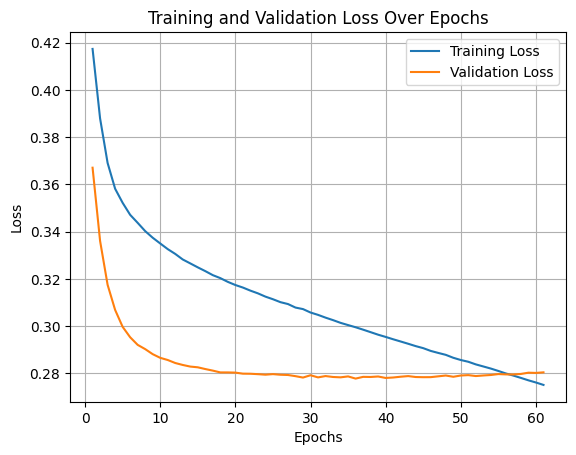

In [143]:
# SimpleClassificationNN test
input_size = bl_X_train.shape[1]
# This is the appropriate loss for binary classification
criterion = nn.BCELoss()
simple_classification_model = SimpleClassificationNN(input_size)
optimizer = torch.optim.Adam(simple_classification_model.parameters(), lr=3e-4, weight_decay=1e-6)

train(simple_classification_model, criterion, optimizer, num_epochs, train_loader, valid_loader)

In [ ]:
# ComplexClassificationNN test
criterion = nn.BCELoss()
complex_classification_model = ComplexClassificationNN(input_size)
optimizer = torch.optim.Adam(complex_classification_model.parameters(), lr=3e-4, weight_decay=1e-6)

train(complex_classification_model, criterion, optimizer, num_epochs, train_loader, valid_loader)

In [ ]:
def evaluate_and_plot_metrics(model, data_loader):
    model.eval()
    all_targets = []
    all_prob_scores = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            logits = model(inputs)
            probabilities = torch.sigmoid(logits)
            all_prob_scores.extend(probabilities.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())


    all_prob_scores = np.array(all_prob_scores).flatten()
    all_targets = np.array(all_targets).flatten()
    pred_labels = (all_prob_scores >= 0.5).astype(int)


    precision = precision_score(all_targets, pred_labels, zero_division=0)
    recall = recall_score(all_targets, pred_labels)
    f1 = f1_score(all_targets, pred_labels)
    roc_auc = roc_auc_score(all_targets, all_prob_scores)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')


    fpr, tpr, _ = roc_curve(all_targets, all_prob_scores)
    plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    return precision, recall, f1, roc_auc

In [ ]:
precision, recall, f1, roc_auc = evaluate_and_plot_metrics(simple_classification_model, valid_loader)
precision, recall, f1, roc_auc = evaluate_and_plot_metrics(complex_classification_model, valid_loader)

## Classification - Assignment 4

In [145]:
from statsmodels.stats.contingency_tables import mcnemar

In [161]:
# McNemera's test (Box 11.3.2 ???? It was not that)
def mcnemar_confidence_interval(b, c, alpha=0.05):
    """
    Calculate the confidence interval for the difference in paired proportions (b-c).
    Uses the normal approximation for the distribution of the test statistic under the null hypothesis.
    
    :param b: The number of instances classifier 1 is correct and classifier 2 is not.
    :param c: The number of instances classifier 2 is correct and classifier 1 is not.
    :param alpha: Significance level for the confidence interval.
    :return: The confidence interval as a tuple (lower_bound, upper_bound).
    """
    z_score = stats.norm.ppf(1 - alpha/2)
    standard_error = np.sqrt(b + c)
    point_estimate = b - c
    margin_of_error = z_score * standard_error
    
    lower_bound = point_estimate - margin_of_error
    upper_bound = point_estimate + margin_of_error
    
    return lower_bound, upper_bound

In [162]:
def get_predictions(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    
    with torch.no_grad():  # No need to track gradients for prediction
        for inputs, _ in data_loader:
            outputs = model(inputs)
            predicted_classes = (outputs > 0.5).type(torch.float)  # Apply a threshold to get binary class predictions
            all_predictions.extend(predicted_classes.cpu().numpy())  # Move predictions to CPU and convert to numpy

    return np.array(all_predictions).flatten()  # Flatten to 1D array if necessary

In [163]:
# Get predictions from both models
simple_ann_preds = get_predictions(simple_classification_model, valid_loader)
complex_ann_preds = get_predictions(complex_classification_model, valid_loader)

# Assuming bl_y_test is a numpy array containing the true binary class labels for the validation set
true_labels = bl_y_test.numpy().flatten()

# Calculate the values for b and c from the contingency table
b = ((simple_ann_preds == 1) & (complex_ann_preds == 0) & (true_labels == 1)).sum()
c = ((simple_ann_preds == 0) & (complex_ann_preds == 1) & (true_labels == 1)).sum()

# Perform McNemar's test
result = mcnemar([[b, c], [c, b]], exact=False, correction=True)
print(f"Test statistic: {result.statistic}, p-value: {result.pvalue}")

# Calculate the confidence interval if needed
ci_lower, ci_upper = mcnemar_confidence_interval(b, c)
print(f"Confidence interval for the difference in paired proportions: ({ci_lower:.2f}, {ci_upper:.2f})")

# Interpret the p-value
alpha = 0.05
if result.pvalue < alpha:
    print("Reject the null hypothesis: There is a significant difference between the two classifiers.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two classifiers.")


Test statistic: inf, p-value: 0.0
Confidence interval for the difference in paired proportions: (0.00, 0.00)
Reject the null hypothesis: There is a significant difference between the two classifiers.


### Performance Testing

Metrics for Regression:
- R2

Metrics for Classification :
- Precision and Recall
- F1 Score
- ROC Curve and AUC

Outcomes:
- If the model is underperforming, consider increasing the number of **layers** or **units**.
- If the model is overfitting, try reducing the complexity, adding **dropout** layers, or increasing **regularization**.

So for regression, I will create a **SimpleANN**, a **ComplexANN** and a **FinalANN** and compare them performance wise.
The number of **epochs** and **learning rate** will be the same when comparing their performance.

Same for classification, we create two models, one SimpleClassificationNN and one ComplexClassificationNN with a high number of layers and dropout.